# How to use nuc_syndat to sample a synthetic, true cross section

The purpose of the nuc_syndat package is to generate synthetic experimental neutron cross section data for incident neutron energies corresponding to the Resolved Resonance Range. The purpose of this synthetic data is to be used as training data for a set of algorithms (ATARI) that help automate a large portion of the evaluation process.

This package was developed as a part of Noah Walton's<sup>1</sup> disseration work in collaboration with Jesse Brown<sup>2</sup> and Vladimir Sobes<sup>1</sup>.


<sup>1</sup> The University of Tennessee </br>
<sup>2</sup> Oak Ridge National Lab


In [3]:
import syndat
import os
import numpy as np
from matplotlib.pyplot import *
# import nuctools as nuc
import pandas as pd
import scipy.linalg as spla

In [4]:
%matplotlib widget


### Define energy grid 

Energy grid data should be linear in time of flight, but is often then grouped together by the experimentalist before it is passed to the evaluator. This grouping is artisanal, and therefore difficult to come up with a generalized way to emulate it. For now, we will pull the tof from an experiment done at RPI.


In [5]:

estruct_lst = syndat.sammy_interface.readlst('../synthetic_data/Ta181/estruct_rpi_open')
estruct_lst.sort_values('E', inplace=True)
estruct_lst.reset_index(drop=True, inplace=True)
energy = estruct_lst.E

### Get average parameters
You can run SAMMY to interpret ENDF files. This creates a SAMQUA.PAR file that contains the RRR parameters as evaluated in ENDF. The function read_sammy_par in sammy_interface reads this file and returns a dataframe with average parameters and all parameters. 

Note: The reduced width average parameters are not corrected for small (PT) widths that are likely missed. This should be updated.

In [6]:

average_parameters, parameters = syndat.sammy_interface.read_sammy_par('../synthetic_data/Ta181/endf_eval/SAMQUA.PAR')
print(average_parameters);# print(parameters)

           dE         Gg         Gn
2.0  7.929756  55.619048  18.222876
1.0  9.764375  56.515152  21.188554


## Generate a theoretical cross section

The next few steps use syndat to sample theoretical resonance parameters and calculate a theoretical cross section/transmission on an experimental energy grid.

### Spin group determination

The syndat package has a set of functions that calculate possible spin groups given some set of nuclear parameters for the incident/target particle. Each spin group has a sequence of resonances (or excited states), the parameters for which have been observed to fall on well established statistical distributions. This is important in the context of generating a synthetic cross section, each spin group will have a statistically sampled resonance sequence that will contribute to the "observed" cross section.

Spin groups are characterized by a particular total orbital angular momentum and parity ($J^{\pi}$) which is a function of the channel spin ($\vec{s}$) and the orbital angular momentum of the pair ($\vec{l}$)

<br/> $\vec{s} = \vec{i} + \vec{I}$ <br/> $\vec{J^{\pi}} = \vec{l}+\vec{s} $ <br/>

Where $\vec{i}$ and $\vec{I}$ are the angular momenta of the incident and target particle respectively. The orbital angular moment of the pair ($\vec{l}$) corresponds to a Legendre expansion of the angular momenta eigenfunctions in the cross section formalism and are often described as s-wave, p-wave, d-wave, f-wave... and so-on channels (l=0,1,2,3). Consequently, a large number of l-values can be considered, however, the cross section observed converges quickly as higher order waves have an decreasing probability of penetrating the centrifugal barrier (the partial width, is driven down by the penetrability factor applied to the reduced width amplitudes). Each of the functions above are quantized vector sums calculated as:

<br/> $|\vec{l}-\vec{l'}| \leq L \leq \vec{l}+\vec{l'} $<br/> 

and each of the quantum numbers have an associated parity that is conserved as a multiplication:

<br/> (-)(+)=(-)<br/> (+)(+)=(+)<br/> (-)(-)=(+)

The syndat code has the capability to do this spin group mapping to determine the allows channels. The following code cell shows an example of how this is done using the map_quantum_numbers function within the spin_groups module. The function returns ordered lists for the possible total orbital angular momenta for positive and negative parity and give the option to print out a summary. 

In [7]:
ac = 8.1271e-15 # scattering radius in m 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 0       # highest order l-wave to consider

pair = syndat.particle_pair(ac, M, m, I, i, l_max)

pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for negative parity
(J-, #Chs, l-waves)

Spin group data for positive parity
(J+, #Chs, l-waves)
(3.0, 1, [0.0])
(4.0, 1, [0.0])


### Resonance sequence sampling

Each spin group has a sequence of resonances who's parameters fall on well established statistical distributions independent of the other spin groups. The syndat code also has this capability with the function sample_all_Jpi in the spin_groups module. In fact, the previous step of quantum spin group mapping is unnecessary as this function will do the mapping again (this is why the print_out function is now set to false).

Statistical distributions of resonance parameters are relative to the average value of the parameter... elaborate here.

In [8]:

Davg = [list(), list([average_parameters.dE[1],average_parameters.dE[2]])]
Ggavg = [list(), list([average_parameters.Gg[1],average_parameters.Gg[2]])]
Gnavg = [list(), list([average_parameters.Gn[1],average_parameters.Gn[2]])]


In [9]:

RRR_Erange = [1, 600]
save_csv = True

pair.sample_all_Jpi(RRR_Erange, 
                        Davg, Ggavg, Gnavg,
                        save_csv = True, 
                        sammy_run_folder = '../synthetic_data/Ta181/postdoc_testdata/')


No average level spacing given for negative parity spin groups


In [10]:
# chack how many resonances in each spin group
# len(Jp_ladders[0])
# pair.Jp_resonances


### From parameters to cross section

Syndat has a sammy_interface module that can create input files for use with the SAMMY code from ORNL. The next few sections of code use syndat to create appropriate SAMMY input files. The must then be run externally by the user because syndat has not integrated the capabilities of SAMMY.

This is currently commented out s.t. the resampled resonances will not overwrite the initially sampled parameters ran through SAMMY for this demonstration.

In [11]:
# syndat.sammy_interface.create_sammyinp('../synthetic_data/Ta181/postdoc_testdata/sammy.inp', template='../templates/sammy_template_noexp.inp')
# syndat.sammy_interface.create_sammypar(Jn_ladders, Jp_ladders,'../synthetic_data/Ta181/postdoc_testdata/sammy.par')

# samtools_array = syndat.sammy_interface.create_samtools_array_from_J(Jn_ladders, Jp_ladders)
# syndat.sammy_interface.samtools_fmtpar(samtools_array, '../synthetic_data/Ta181/postdoc_testdata/sammy.par', \
#                                         template = os.path.realpath("../templates/sammy_template.par"))

In [12]:
# syndat.sammy_interface.write_estruct_file(energy, '../synthetic_data/Ta181/postdoc_testdata/estruct')

In [13]:
# Or! create sammy files for a number of resonance ladder realizations with 
# the Module for Multiple DataSet Acquisition (MMDA)

# case_directory= "/Users/nwx/work/synthetic_data/"  #!!! give an appropriate case directory
# number_of_realizations = 5
# 
# syndat.MMDA.wrapped_sammy_file_creator(number_of_realizations, case_directory, Estruct, \
#                                I, i, l_wave_max,
#                                RRR_Erange,  
#                                Davg, Gavg,  
#                                Gavg_swave,  
#                                print_out,  
#                                save_csv)

In [14]:

# somehow, somehwere, somebody can run the each of the created sammy's 
# in the realization directories <case_directory>/realization_#/
# I have set the directory structure to read a sammy LST I have run and included in the github repo

### Read SAMMY output

Rememeber, SAMMY must be run externally before moving on to the next code sections. There are a number of pre-calculated SAMMY output files in the syndat repo, however, these must be recalculated if a different analysis has been done.

SAMMY has taken the energy grid and generated resonance parameters and calculated the theoretical total cross section and/or transmission. Syndat has a set of tools to read and parse the SAMMY.LST output file. Because the only goal of this SAMMY execution is to generate a theoretical cross section, you'll notice most variables read from the LST are useless. This is because the syndat.sammy_interface.write_estruct function puts 1.0 for all experimental data points and uncertainty, because the sammy.inp file is flagged to not run bayes, these columns are not used. The only columns from the LST that should be used after this step are the theoretical cross section (theo_xs) and the theoretical transmission (theo_trans).

In [15]:
output = syndat.sammy_interface.readlst('../synthetic_data/Ta181/postdoc_testdata/SAMMY1_cap.LST')
output

,E,exp_dat,exp_dat_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,2.549463,1.0,1.0,6.543364e-02,NaN,NaN,NaN,NaN,NaN
1,2.635479,1.0,1.0,6.831303e-02,NaN,NaN,NaN,NaN,NaN
2,2.681543,1.0,1.0,6.999749e-02,NaN,NaN,NaN,NaN,NaN
3,2.684373,1.0,1.0,7.010444e-02,NaN,NaN,NaN,NaN,NaN
4,2.687208,1.0,1.0,7.021199e-02,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16000,14042.545831,1.0,1.0,1.300000e-08,NaN,NaN,NaN,NaN,NaN
16001,14076.099164,1.0,1.0,1.290000e-08,NaN,NaN,NaN,NaN,NaN
16002,14109.772901,1.0,1.0,1.280000e-08,NaN,NaN,NaN,NaN,NaN
16003,14143.567618,1.0,1.0,1.280000e-08,NaN,NaN,NaN,NaN,NaN


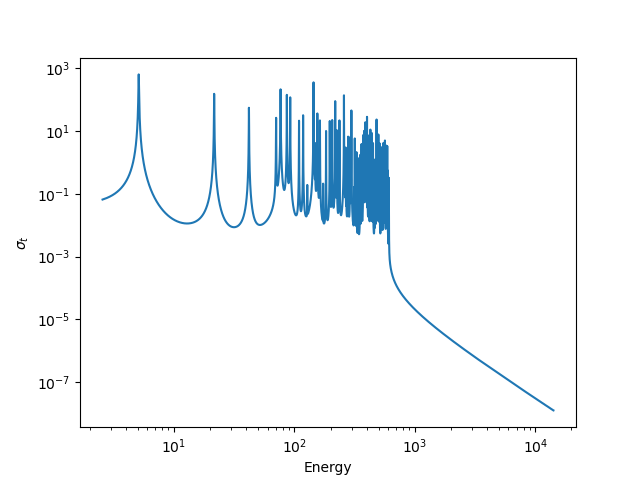

In [16]:
figure()
plot(output.E, output.theo_xs)
xscale('log'); yscale('log')
xlabel('Energy'); ylabel(r'$\sigma_{t}$')
show()

# Add experimental noise

Now that we have generated a synthetic total cross section (with no experimental corrections in this case), we can use the syndat code package to add noise to the theoretical cross section/transmission.

The first section of code shows how to use the syndat package to add noise directly to the theoretical cross section using functions within syndat. The second section will outline how to do this more rigorously and with high level modules in the syndat package that perform a number of functions.

In [17]:

gausian_noise_xs = syndat.exp_effects.gaus_noise(output.theo_xs, np.sqrt(output.theo_xs))
poisson_noise_xs = syndat.exp_effects.pois_noise(output.theo_xs)
# gausian_noise_xs = np.where(gausian_noise_xs<0,1e-5,gausian_noise_xs)
output['exp'] = gausian_noise_xs

output['exp_unc'] = gausian_noise_xs*.2
output
# np.sqrt(0)


,E,exp_dat,exp_dat_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes,exp,exp_unc
0,2.549463,1.0,1.0,6.543364e-02,NaN,NaN,NaN,NaN,NaN,-0.170530,-3.410591e-02
1,2.635479,1.0,1.0,6.831303e-02,NaN,NaN,NaN,NaN,NaN,0.183096,3.661926e-02
2,2.681543,1.0,1.0,6.999749e-02,NaN,NaN,NaN,NaN,NaN,-0.031739,-6.347734e-03
3,2.684373,1.0,1.0,7.010444e-02,NaN,NaN,NaN,NaN,NaN,0.042579,8.515745e-03
4,2.687208,1.0,1.0,7.021199e-02,NaN,NaN,NaN,NaN,NaN,-0.041752,-8.350396e-03
...,...,...,...,...,...,...,...,...,...,...,...
16000,14042.545831,1.0,1.0,1.300000e-08,NaN,NaN,NaN,NaN,NaN,0.000018,3.553053e-06
16001,14076.099164,1.0,1.0,1.290000e-08,NaN,NaN,NaN,NaN,NaN,-0.000011,-2.194805e-06
16002,14109.772901,1.0,1.0,1.280000e-08,NaN,NaN,NaN,NaN,NaN,-0.000063,-1.263105e-05
16003,14143.567618,1.0,1.0,1.280000e-08,NaN,NaN,NaN,NaN,NaN,-0.000003,-6.667720e-07


### Plot the converted cross section data

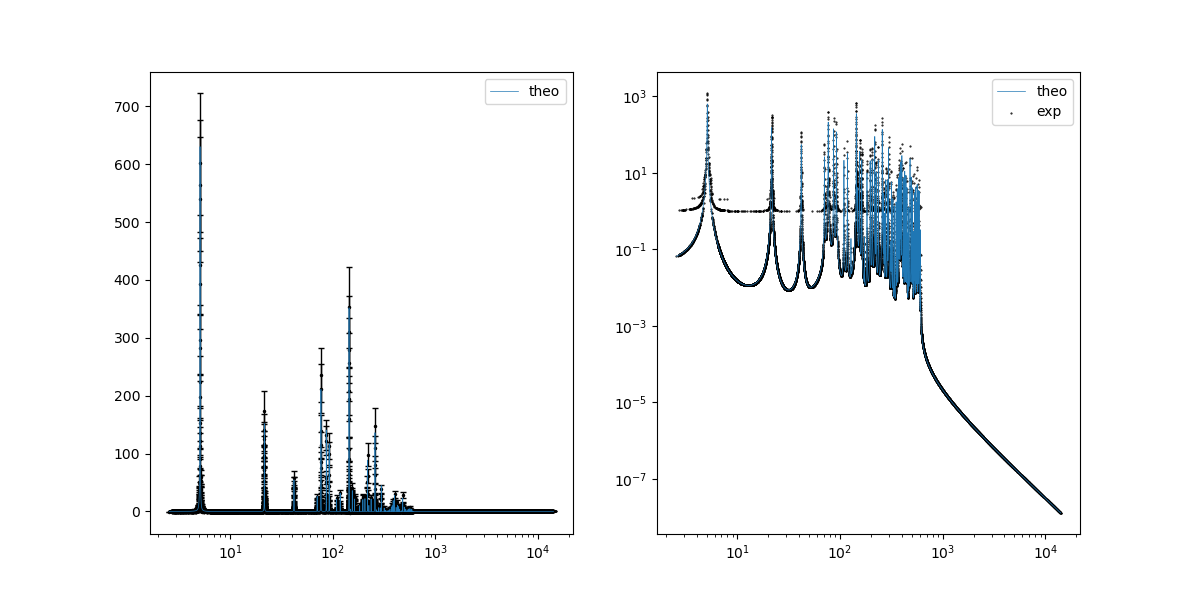

In [18]:


fig, ax = subplots(1,2,figsize=(12,6))

# ax[0].plot(red.trans.E, red.trans.theo, label='theo', linewidth=.5)
ax[0].errorbar(output.E, output.exp, yerr=output.exp_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1)
ax[0].plot(output.E, output.theo_xs, label='theo', linewidth=.5, zorder=3)
# ax[0].scatter(output.E, gausian_noise_xs, marker='.', color='k', s=1, label='exp')
ax[0].set_xscale('log'); 
# ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(output.E, output.theo_xs, label='theo', linewidth=.5)
ax[1].scatter(output.E, poisson_noise_xs, marker='.', color='k', s=1, label='exp')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].legend()

syndat.sammy_interface.write_samdat(output[['E','exp','exp_unc']],'../examples/sammy1_cap.dat')

# Syndat - A more rigorous methodology for creating realistic experimental data - Transmission only
The evaluation process takes reduced experimental data and fits an experimentally corrected theoretical model to that data. We will call this the evaluation point or evaluation object. For now, it is assumed that the theoretical model can be statistically generated such that the output cross section is a potential realization of the true cross section, just not the realization of the true cross section that is observed in our world (or perhaps there is a very very small probability that the same exact realization is statistically generated as is observed). Because this evaluation object is directly compared to the reduced experimental data, if we assume we have the true theoretical model, we can assume we have the true set of reduced experimental data with zero noise and zero uncertainty. 

To do this, create an experiment object with syndat. If the perform_methods arguement is True, the experiment will generate raw experimental count data from the theoretically true cross section, then add appropriate noise and reduce that data back as well as propagate uncertainty.

A more in depth discussion of the methodology can be found in the article associated with this work. <a href="https://www.overleaf.com/read/gygkwfqyfpqv" target="_new">Walton, et al.</a>


In [19]:
opendata = '../synthetic_data/Ta181/rpi-open-ta181.csv'
sammy_xs = '../synthetic_data/Ta181/endf_eval/SAMMY.LST'
# opendata = '../synthetic_data/Ta181/smooth-open-Ta181.csv'  # the energy/tof grid must match that of the theoretical cross section!!
# sammy_xs = '../synthetic_data/Ta181/postdoc_testdata/SAMMY2.LST'
# sammy_xs = '/Users/noahwalton/Documents/GitHub/nuc_syndat/synthetic_data/Ta181/verify_slbw/SAMMY.LST'

In [20]:

# generation/reduction options
perform_methods = True
add_noise = True
default_exp = True

exp = syndat.experiment(perform_methods, default_exp, add_noise, opendata, sammy_xs)



### Plot the experimental count rate data

The experiment object houses a lot of information:</br>
    - count rate data (with uncertainties) for sample in and sample out data </br>
    - transmission data with uncertainty, clean and noisey </br>
    - other things

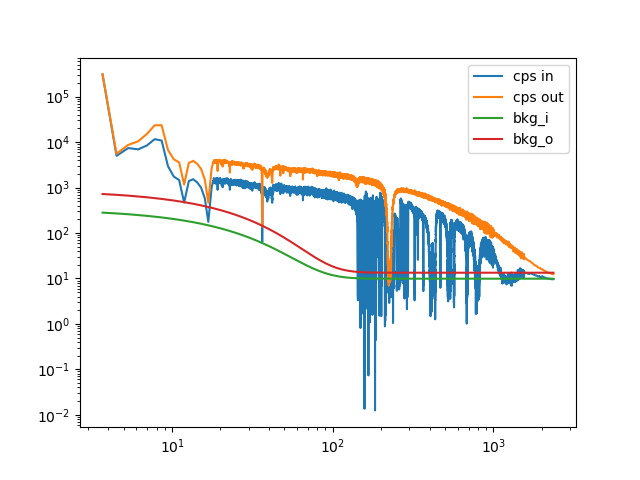

In [21]:
trans = exp.trans
cov = exp.CovT
tof = exp.trans.tof

figure()
plot(tof,exp.sdat.cps, label='cps in'); 
plot(tof,exp.odat.cps, label='cps out'); 
xscale('log'); yscale('log')
plot(tof, exp.redpar.val.ks*exp.Bi+exp.redpar.val.b0s, label='bkg_i')
plot(tof, exp.redpar.val.ko*exp.Bi+exp.redpar.val.b0o, label='bkg_o')
legend()

### Visualize the transmission data 

(150, 175)

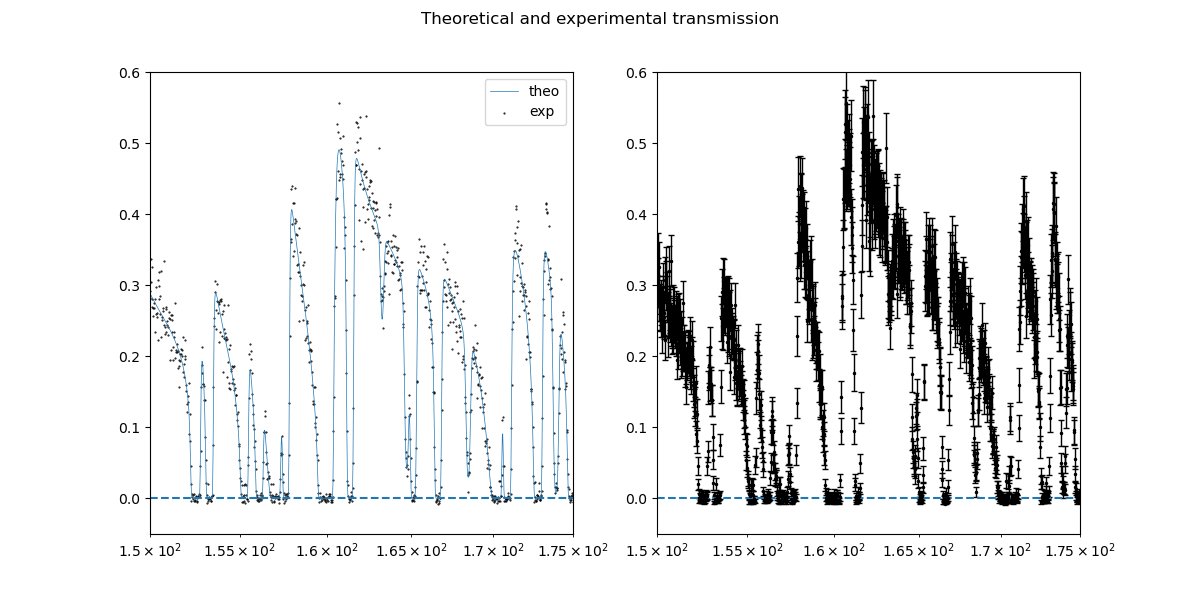

In [28]:
fig,ax = subplots(1,2, figsize=(12,6))
suptitle('Theoretical and experimental transmission')

ax[0].plot(exp.trans.tof, exp.trans.theo_trans, linewidth=0.5, label='theo')
ax[0].scatter(exp.trans.tof, exp.trans.exp_trans, marker='.', color='k', s=1, label='exp')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_ylim([-0.05,0.6])
ax[0].axhline(y=0.0, ls='--')

ax[1].scatter(exp.trans.tof, exp.trans.exp_trans, marker='.', color='k', s=1, label='exp')
ax[1].errorbar(exp.trans.tof, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
ax[1].set_ylim(3,250)
ax[1].set_xscale('log')
ax[1].axhline(y=0.0, ls='--')
ax[1].set_ylim([-0.05,0.6])

# ax[0].set_xlim([150,175])
# ax[1].set_xlim([150,175])

#### Note

There is some visual structure in the noise/uncertainty of the data that corresponds to the binning stucture used. The spacing between data points is linear in TOF and therefore decreasing with energy, furthermore the flux spectra is just stronger at shorter tof's/higher energies. This causes the conical increase in noise/uncertainty as you move up in tof. The sharp decreases in noise/uncertainty that disrupt this trend are caused by a change in the binning structure. If you increase the width of a tof bin, more counts will contribute to that data point, decreasing the uncertainty/noise.

In [29]:

# fig,ax = subplots(1,2, figsize=(12,6))
# suptitle('Theoretical and experimental transmission')

# # ax[0].plot(exp.trans.tof, exp.trans.exp_xs, linewidth=0.5, label='theo')
# ax[0].scatter(exp.trans.tof, exp.trans.exp_trans, marker='.', color='k', s=1, label='exp')
# ax[0].set_xscale('log')
# ax[0].legend()
# ax[0].set_ylim([-0.05,0.6])
# ax[0].axhline(y=0.0, ls='--')

# ax[1].scatter(exp.trans.tof, exp.trans.exp_trans, marker='.', color='k', s=1, label='exp')
# ax[1].errorbar(exp.trans.tof, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
# ax[1].set_ylim(3,250)
# ax[1].set_xscale('log')
# ax[1].axhline(y=0.0, ls='--')
# ax[1].set_ylim([-0.05,0.6])

# # ax[0].set_xlim([100,150])
# # ax[1].set_xlim([100,150])

# Verification of the Synthetic data

One simple verification of this generation/reduction process is to step through it without adding noise, you should get out the same cross section as you started with (within numerical precision). Set add_noise to False and run the following code:

In [24]:
# sum(abs(trans.theo-trans.expT))

### Checking Stability in SAMMY

Another simple verification of the output of nuc_syndat is to run the data through the GLS regression in SAMMY to ensure it is numerically stable. If you take the synthetic experimental data and run it through SAMMY, it is able to perform the bayesian fitting procedure given the set of starting parameters (ENDF resonance parameters). The Posterior is slightly different due to the noise added, but the system is numerically stable through the bayesian update. Furthermore, the reduced experimental data and output from SAMMY can be compared to the real experimental data reduced and evaluated by Brown, J., et al.

The points in the total cross section that look out of place are a function of negative transmission values. The SAMMY code assigns an arbitrary value (~200 b) to cross section values when transmission goes negative because the alternative would go to infinity. This artifact is one of the reasons resonance parameters are fit to transmission rather than total cross section.

In [25]:

lst = syndat.sammy_interface.readlst("/Users/noahwalton/Documents/GitHub/nuc_syndat/synthetic_data/Ta181/newdat/SAMMY.LST")

fig, ax = subplots(1,2, figsize=(16,6))
ax[0].scatter(lst.E, lst.exp_trans, s=1, c='k', label='exp')
ax[0].plot(lst.E, lst.theo_trans, lw=1, label='prior')
ax[0].plot(lst.E, lst.theo_trans_bayes, lw=1, label='post')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title('Transmission')


ax[1].scatter(lst.E, lst.exp_xs, s=1, c='k', label='exp')
ax[1].plot(lst.E, lst.theo_xs, lw=1, label='prior')
ax[1].plot(lst.E, lst.theo_xs_bayes, lw=1, label='post')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_title('Total Cross Section')

fig.suptitle('My Reduced Data')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/noahwalton/Documents/GitHub/nuc_syndat/synthetic_data/Ta181/newdat/SAMMY.LST'

### Compare to real experimental data from Brown, J.

Text(0.5, 0.98, 'Brown, J. Reduced Data')

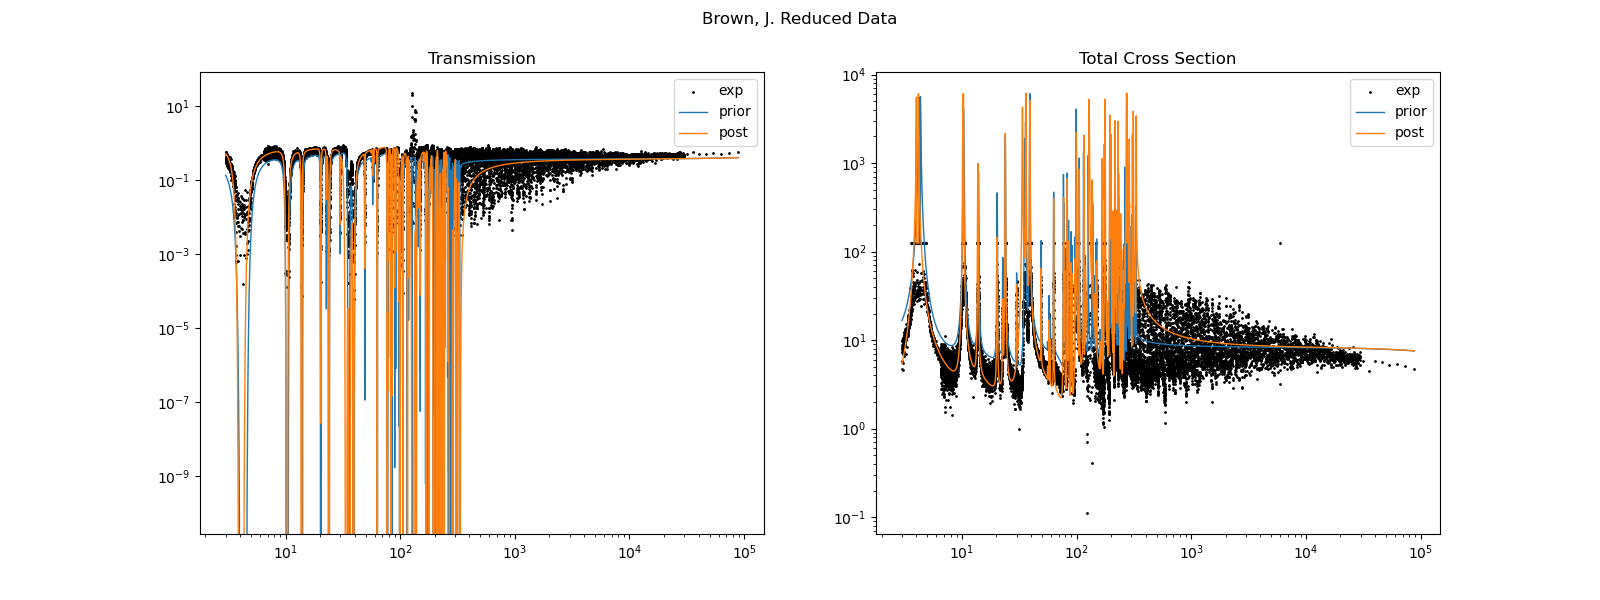

In [32]:
sol_lst = syndat.sammy_interface.readlst("../synthetic_data/Ta181/JB_sol/SAMMY.LST")

fig, ax = subplots(1,2,figsize=(16,6))
ax[0].scatter(sol_lst.E, sol_lst.exp_trans, s=1, c='k', label='exp')
ax[0].plot(sol_lst.E, sol_lst.theo_trans, lw=1, label='prior')
ax[0].plot(sol_lst.E, sol_lst.theo_trans_bayes, lw=1, label='post')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title('Transmission')

ax[1].scatter(sol_lst.E, sol_lst.exp_dat, s=1, c='k', label='exp')
ax[1].plot(sol_lst.E, sol_lst.theo_xs, lw=1, label='prior')
ax[1].plot(sol_lst.E, sol_lst.theo_xs_bayes, lw=1, label='post')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_title('Total Cross Section')

fig.suptitle('Brown, J. Reduced Data')

# Create SAMMY.DAT files from the generated experimental data

Now that we have a set of noisy, experimental data with associated uncertainty, we can use syndat to put it into a convenient format. One such format is that of the SAMMY.DAT file. This file is read by SAMMY as the experimental data file (energy, value, and uncertainty) and used for the energy grid, bayesian update (GLS), and uncertainty estimation. This is the same file as 'estruct', however, in that case we only cared about the energy grid, the experimental data points/uncertainty were set to 1.0.

In the following example, we will write the transmission and it's uncertainty to a sammy.dat file.

In [ ]:
exp.trans

,tof,E,theo_trans,exp_trans,exp_trans_unc
0,3.689600,5.313697e+07,0.999199,0.998448,0.024104
1,4.508800,4.659825e+06,0.972832,0.975803,0.029275
2,5.328000,1.618690e+06,0.890059,0.890979,0.024151
3,6.147200,8.140801e+05,0.678586,0.677322,0.018001
4,6.966400,4.886650e+05,0.560548,0.562571,0.014460
...,...,...,...,...,...
16041,2153.449447,1.399729e+00,0.350182,-0.035616,1.195574
16042,2205.877936,1.333885e+00,0.351858,-0.249505,4.837469
16043,2258.307498,1.272579e+00,0.353064,0.705264,1.878041
16044,2310.735437,1.215406e+00,0.353876,0.146507,0.330691


In [ ]:

# syndat.sammy_interface.write_samdat(exp.trans[['E','exp_xs','exp_xs_unc']],'../examples/sammy2.dat')
syndat.sammy_interface.write_samdat(exp.trans[['E','exp_trans','exp_trans_unc']],'../synthetic_data/Ta181/postdoc_testdata/sammy1_trans.dat')


In [33]:
test = syndat.sammy_interface.readlst('../synthetic_data/Ta181/postdoc_testdata/sammy2_trans.dat')
test


,E,exp_dat,exp_dat_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,14177.483896,0.386795,0.028866,NaN,NaN,NaN,NaN,NaN,NaN
1,14143.567618,0.405099,0.029814,NaN,NaN,NaN,NaN,NaN,NaN
2,14109.772901,0.342038,0.026973,NaN,NaN,NaN,NaN,NaN,NaN
3,14076.099164,0.360274,0.027796,NaN,NaN,NaN,NaN,NaN,NaN
4,14042.545831,0.381869,0.028307,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16000,2.687208,0.444400,0.095436,NaN,NaN,NaN,NaN,NaN,NaN
16001,2.684373,0.310605,0.113549,NaN,NaN,NaN,NaN,NaN,NaN
16002,2.681543,0.333228,0.110229,NaN,NaN,NaN,NaN,NaN,NaN
16003,2.635479,0.366615,0.031526,NaN,NaN,NaN,NaN,NaN,NaN


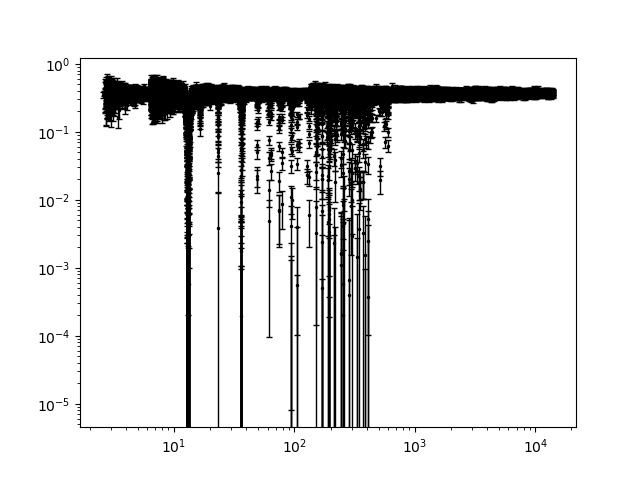

In [36]:
figure()
# scatter(test.E, test.exp_xs, marker='.', color='k', s=1, label='exp')
errorbar(test.E, test.exp_dat, yerr=test.exp_dat_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
xscale('log'); yscale('log')